In [1]:
import matplotlib.pyplot as plt

import torch
import torch.distributions as dist
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
from src.loss import snn_loss

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def generate_data(n: int):
    """n: size of each Gaussian blob."""
    z_s00 = torch.randn(n, 2) * 2
    z_s10 = torch.randn(n, 2) * 2 + 3
    z_s0 = torch.cat([z_s00, z_s10], dim=0)

    z_s01 = torch.randn(n, 2) * 2 + torch.tensor([[-5, 5]])
    z_s11 = torch.randn(n, 2) * 2 + torch.tensor([[-1, 7]])
    z_s1 = torch.cat([z_s01, z_s11], dim=0)

    z_s02 = torch.randn(n, 2) * 2 + torch.tensor([[-5, -5]])
    z_s12 = torch.randn(n, 2) * 2 + torch.tensor([[-1, -7]])
    z_s2 = torch.cat([z_s02, z_s12], dim=0)

    z_s = torch.cat([z_s0, z_s1, z_s2], dim=0)


    content_label = torch.tensor([0] * 2 * n + [1] * 2 * n + [2] * 2 * n)
    style_label = torch.tensor(([0] * n + [1] * n) * 3)

    return z_s, content_label, style_label

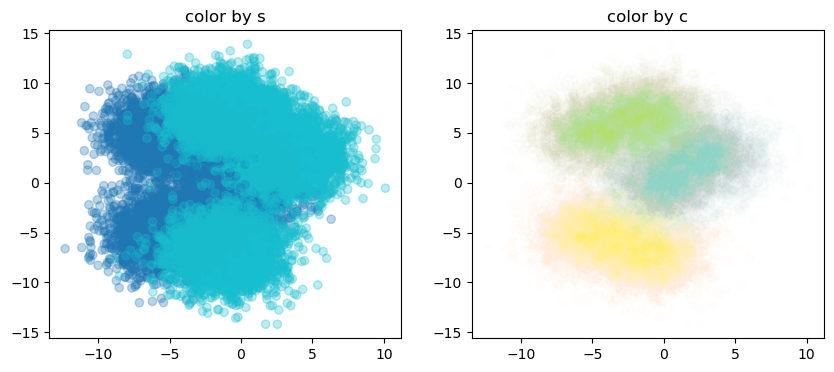

In [8]:
z_s, content_label, style_label = generate_data(3000)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(z_s[:, 0], z_s[:, 1], c=style_label, cmap="tab10", alpha=0.3)
axs[0].set_title("color by s")
axs[1].scatter(z_s[:, 0], z_s[:, 1], c=content_label, cmap="Set3",  alpha=0.01)
axs[1].set_title("color by c")
plt.show()

In [9]:
data = TensorDataset(
    z_s, content_label, style_label
)
dataloader = DataLoader(data, batch_size=128, shuffle=True)

100%|██████████| 141/141 [00:00<00:00, 177.03batch/s, loss=0.64] 


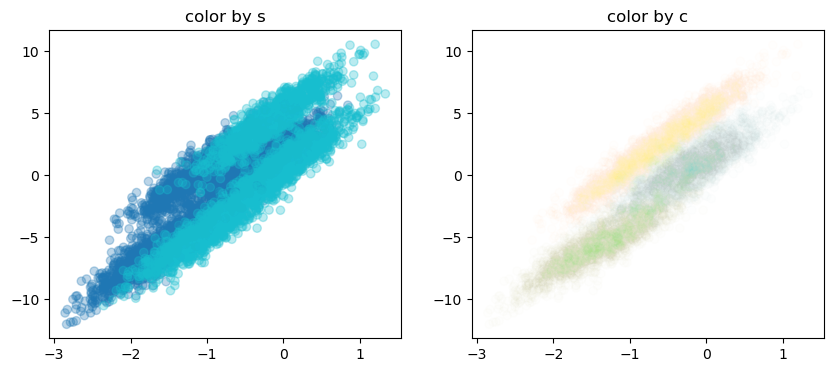

100%|██████████| 141/141 [00:00<00:00, 197.17batch/s, loss=0.52] 


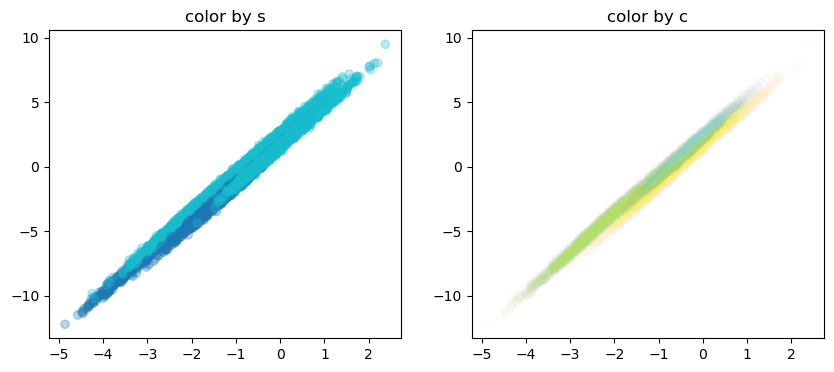

100%|██████████| 141/141 [00:00<00:00, 215.81batch/s, loss=0.5]  


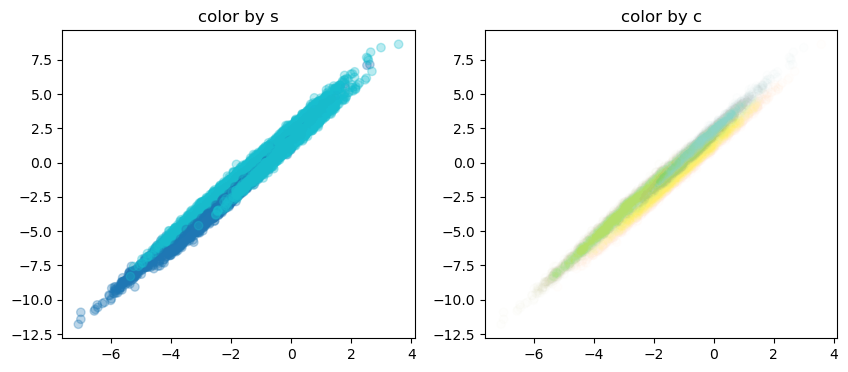

100%|██████████| 141/141 [00:00<00:00, 205.09batch/s, loss=0.512]


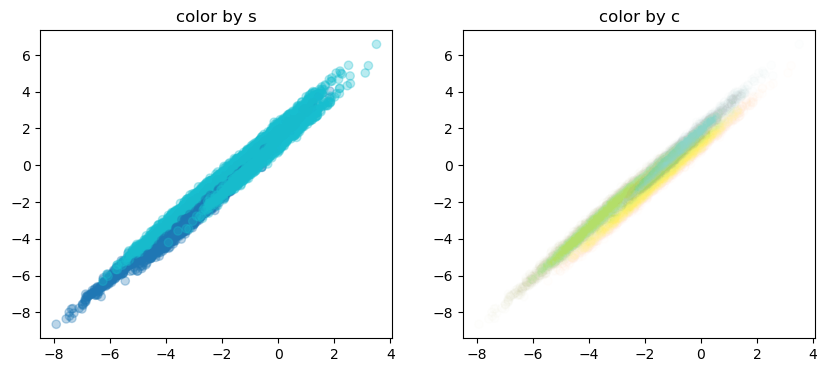

100%|██████████| 141/141 [00:00<00:00, 208.40batch/s, loss=0.497]


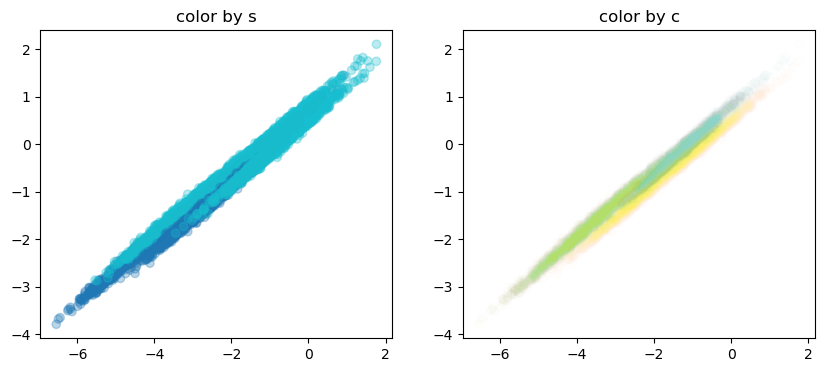

100%|██████████| 141/141 [00:00<00:00, 204.81batch/s, loss=0.408]


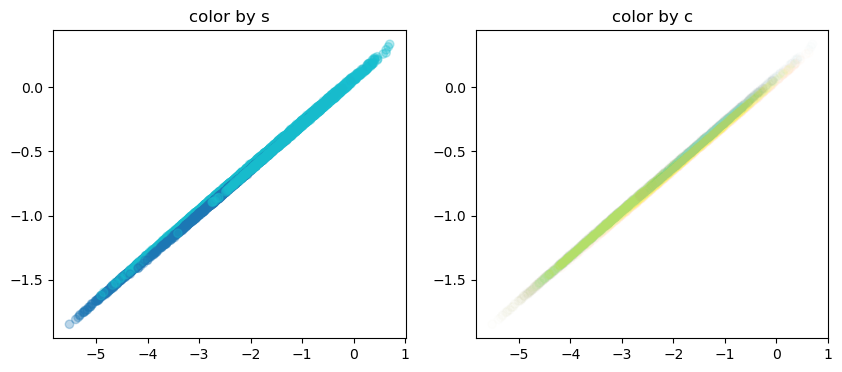

In [17]:
enc = nn.Sequential(
    nn.Linear(2, 2, bias=True),
).to(device)
optimizer = Adam(enc.parameters(), lr=5e-4)
losses = []
plot_data = []
for i in range(26):
    with tqdm(dataloader, unit="batch") as bar:
        for batch in bar:
            optimizer.zero_grad()
            z, y, _ = batch
            z, y = z.to(device), y.to(device)
            z_transformed = enc(z)
            loss = snn_loss(z_transformed, y, temperature=1, flip=True)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=float(loss))
            losses.append(loss.item())
    if i % 5 == 0:
        with torch.no_grad():
            z_s, content_label, style_label = generate_data(1000)
            z_transformed = enc(z_s.to(device)).detach().cpu()
            plot_data.append(
                {
                    "z": z_transformed,
                    "style_label": style_label,
                    "content_label": content_label,
                }
            )
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].scatter(
                z_transformed[:, 0],
                z_transformed[:, 1],
                c=style_label,
                cmap="tab10",
                alpha=0.3,
            )
            axs[0].set_title("color by s")
            axs[1].scatter(
                z_transformed[:, 0],
                z_transformed[:, 1],
                c=content_label,
                cmap="Set3",
                alpha=0.01,
            )
            axs[1].set_title("color by c")
            plt.show()

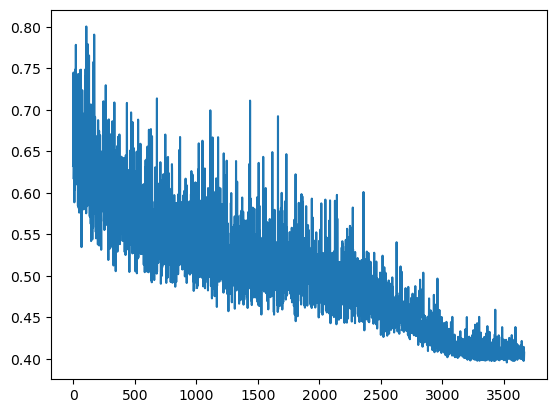

In [18]:
plt.plot(losses)

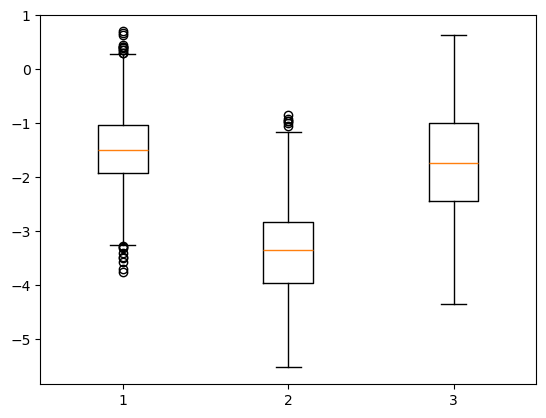

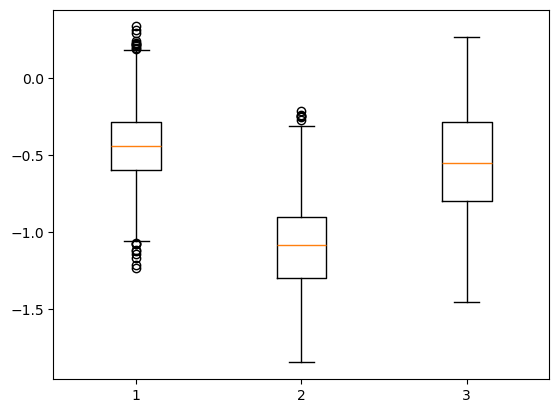

In [19]:
plt.boxplot([z_transformed[:, 0][content_label == i] for i in range(3)])
plt.show()
plt.boxplot([z_transformed[:, 1][content_label == i] for i in range(3)])
plt.show()